# Tropical Cyclone forecast

This notebook introduces the Prithvi-WxC model and demonstrates how to perform a 12 hour forecasting using unrolling.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Model input data

The pre-trained Prithvi-WxC model takes as input three tensors (data cubes) containing different kinds of information:

 - Dynamic input (``x``): A 4-D tensor with shape $(n_t, n_v, n_{lat}, n_{lon})$ containing along its axes the input time steps ($n_t = 2$), the dynamic MERRA-2 variables ($n_v$), the grid-points along the latitudinal dimension, and the grid points along their longitudinal dimension ($n_lon = 576$).
 - Static input (``static``): A tensor with shape $(n_{v_s}, n_{lat}, n_lon{lon})$ containing static input data 
   including the position of each input grid point, the initialization time of the forecast, as well as static MERRA-2 variables.
 - The climatology (``climate``): A tensor with shape $(n_v, n_{lat}, n_{lon})$ containing the climatology for all dynamic variables at the targeted lead time.

## Downloading the data

To be able to perform inference with the Prithvi-WxC model, we first need to download the data required input data. For a given data, we need:

 - MERRA-2 data from these days
 - The static MERRA-2 data
 - Climatology files containing the climatology data used by the Prithvi-WxC model

The ``fm4a`` package provides a helper function to download all required data to perform inference with the Prithvi-WxC model. To use the function you need to make an account with at [NASA EarthData](https://urs.earthdata.nasa.gov/) and [link your](https://urs.earthdata.nasa.gov/approve_app?client_id=e2WVk8Pw6weeLUKZYOxvTQ) account to access the MERRA-2 online archive.

Execute the cell below to download the required input data for a forecasts initialized at August 28, 2021, using a 6-hour time step up to a maximum forecast time of 120 h. The extracted input data for the model will be placed into a folder called ``input_data`` and the downloaded raw data will be stored in a folder ``../data``. 

> **Note**: that the MERRA-2 files are fairly large, so the download will take some time.

     

In [4]:
%rm /home/simon/src/fm4a/data/2021/08/31/MERRA2_401.inst3_3d_asm_Nv.20210831.nc4

In [5]:
import numpy as np
from fm4a.download import get_prithvi_wxc_input

initialization_time =np.datetime64("2021-08-27")
get_prithvi_wxc_input(
    initialization_time,
    6, # The time difference in hours between consecutive model steps.
    5 * 24, # Total maximum lead time.
    "input_data",
    "../data"
)

['2021-08-27T06' '2021-08-27T12' '2021-08-27T18' '2021-08-28T00'
 '2021-08-28T06' '2021-08-28T12' '2021-08-28T18' '2021-08-29T00'
 '2021-08-29T06' '2021-08-29T12' '2021-08-29T18' '2021-08-30T00'
 '2021-08-30T06' '2021-08-30T12' '2021-08-30T18' '2021-08-31T00'
 '2021-08-31T06' '2021-08-31T12' '2021-08-31T18' '2021-09-01T00']


In [24]:
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset
from fm4a.definitions import (
    LEVELS,
    SURFACE_VARS,
    STATIC_SURFACE_VARS,
    VERTICAL_VARS,
)
dataset = Merra2RolloutDataset(
    time_range=("2021-08-26", "2021-08-28"),
    lead_time=120,
    input_time=-6,
    data_path_surface="input_data",
    data_path_vertical="input_data",
    climatology_path_surface="input_data/climatology",
    climatology_path_vertical="input_data/climatology",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    levels=LEVELS,
    positional_encoding="fourier",
)
len(dataset)# > 0, "There doesn't seem to be any valid data."

[Timestamp('2021-08-25 18:00:00'), Timestamp('2021-08-26 00:00:00'), Timestamp('2021-08-26 06:00:00'), Timestamp('2021-08-26 12:00:00'), Timestamp('2021-08-26 18:00:00'), Timestamp('2021-08-27 00:00:00'), Timestamp('2021-08-27 06:00:00'), Timestamp('2021-08-27 12:00:00'), Timestamp('2021-08-27 18:00:00'), Timestamp('2021-08-28 00:00:00'), Timestamp('2021-08-28 06:00:00'), Timestamp('2021-08-28 12:00:00'), Timestamp('2021-08-28 18:00:00'), Timestamp('2021-08-29 00:00:00'), Timestamp('2021-08-29 06:00:00'), Timestamp('2021-08-29 12:00:00'), Timestamp('2021-08-29 18:00:00'), Timestamp('2021-08-30 00:00:00'), Timestamp('2021-08-30 06:00:00'), Timestamp('2021-08-30 12:00:00'), Timestamp('2021-08-30 18:00:00'), Timestamp('2021-08-31 00:00:00')]
[(238, 6), (238, 12), (238, 18), (239, 0), (239, 6), (239, 12), (239, 18), (240, 0), (240, 6), (240, 12), (240, 18), (241, 0), (241, 6), (241, 12), (241, 18), (242, 0), (242, 6), (242, 12), (242, 18), (243, 0)]
[Timestamp('2021-08-25 21:00:00'), Times

0

In [15]:
dataset.valid_climate_timestamps

{(1, 12),
 (1, 18),
 (239, 6),
 (239, 12),
 (239, 18),
 (240, 0),
 (240, 6),
 (240, 12),
 (240, 18),
 (241, 0),
 (241, 6),
 (241, 12),
 (241, 18),
 (242, 0),
 (242, 6),
 (242, 12),
 (242, 18),
 (243, 0),
 (243, 6),
 (243, 12),
 (243, 18),
 (244, 0)}

In [2]:


dataset = Merra2Dataset(
    ("2021-08-26", "2021-08-28T00:00:00"),
    lead_times=[0],
    input_times=[-6],
    data_path_surface="input_data/",
    data_path_vertical="input_data/",
    climatology_path_surface="input_data/climatology/",
    climatology_path_vertical="input_data/climatology/",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    positional_encoding="fourier",
)
len(dataset)

3

In [3]:
data = xr.load_dataset("input_data/MERRA2_sfc_20210826.nc")

In [4]:
data.time.attrs["begin_date"]

20200101

In [5]:
from PrithviWxC.dataloaders.merra2 import preproc
input_data = dataset[0]
input_data = preproc([input_data], {"level": (0, 0), "lon": (0, 0), "lat": (0, -1)})

### MERRA-2 data

### Dynamic input data

The dynamic input data comprises 160 different variables of which the first 20 correspond to different single-level variables and the latter 140 to 10 profiles of vertically-resolved variables at 14 model levels.
 
#### Single-level variables


The following single-level variables correspond the first twenty values in the dynamic input.


| Input Index | Variable | Full Name                                | Units                   |
|-------------|----------|-------------------------------------------|-------------------------|
| 0           | EFLUX    | Latent Heat Flux                          | W/m²                    |
| 1           | GWETROOT | Root Zone Soil Moisture                   | kg/m²                   |
| 2           | HFLUX    | Sensible Heat Flux                        | W/m²                    |
| 3           | LAI      | Leaf Area Index                           | unitless (m²/m²)        |
| 4           | LWGAB    | Surface Absorbed Longwave Radiation       | W/m²                    |
| 5           | LWGEM    | Surface Emitted Longwave Radiation        | W/m²                    |
| 6           | LWTUP    | Top of Atmosphere Upwelling Longwave      | W/m²                    |
| 7           | PS       | Surface Pressure                          | Pa                      |
| 8           | QV2M     | Specific Humidity at 2 Meters             | kg/kg                   |
| 9           | SLP      | Sea Level Pressure                        | Pa                      |
| 10          | SWGNT    | Net Shortwave Radiation at Surface        | W/m²                    |
| 11          | SWTNT    | Net Shortwave Radiation at TOA            | W/m²                    |
| 12          | T2M      | Air Temperature at 2 Meters               | K                       |
| 13          | TQI      | Ice Water Path                            | kg/m²                   |
| 14          | TQL      | Liquid Water Path                         | kg/m²                   |
| 15          | TQV      | Total Precipitable Water Vapor            | kg/m²                   |
| 16          | TS       | Surface Skin Temperature                  | K                       |
| 17          | U10M     | Eastward Wind at 10 Meters                | m/s                     |
| 18          | V10M     | Northward Wind at 10 Meters               | m/s                     |
| 19          | Z0M      | Surface Roughness Length for Momentum     | m                       |

In [6]:
input_data.keys()

dict_keys(['lead_time', 'input_time', 'static', 'x', 'y', 'climate'])

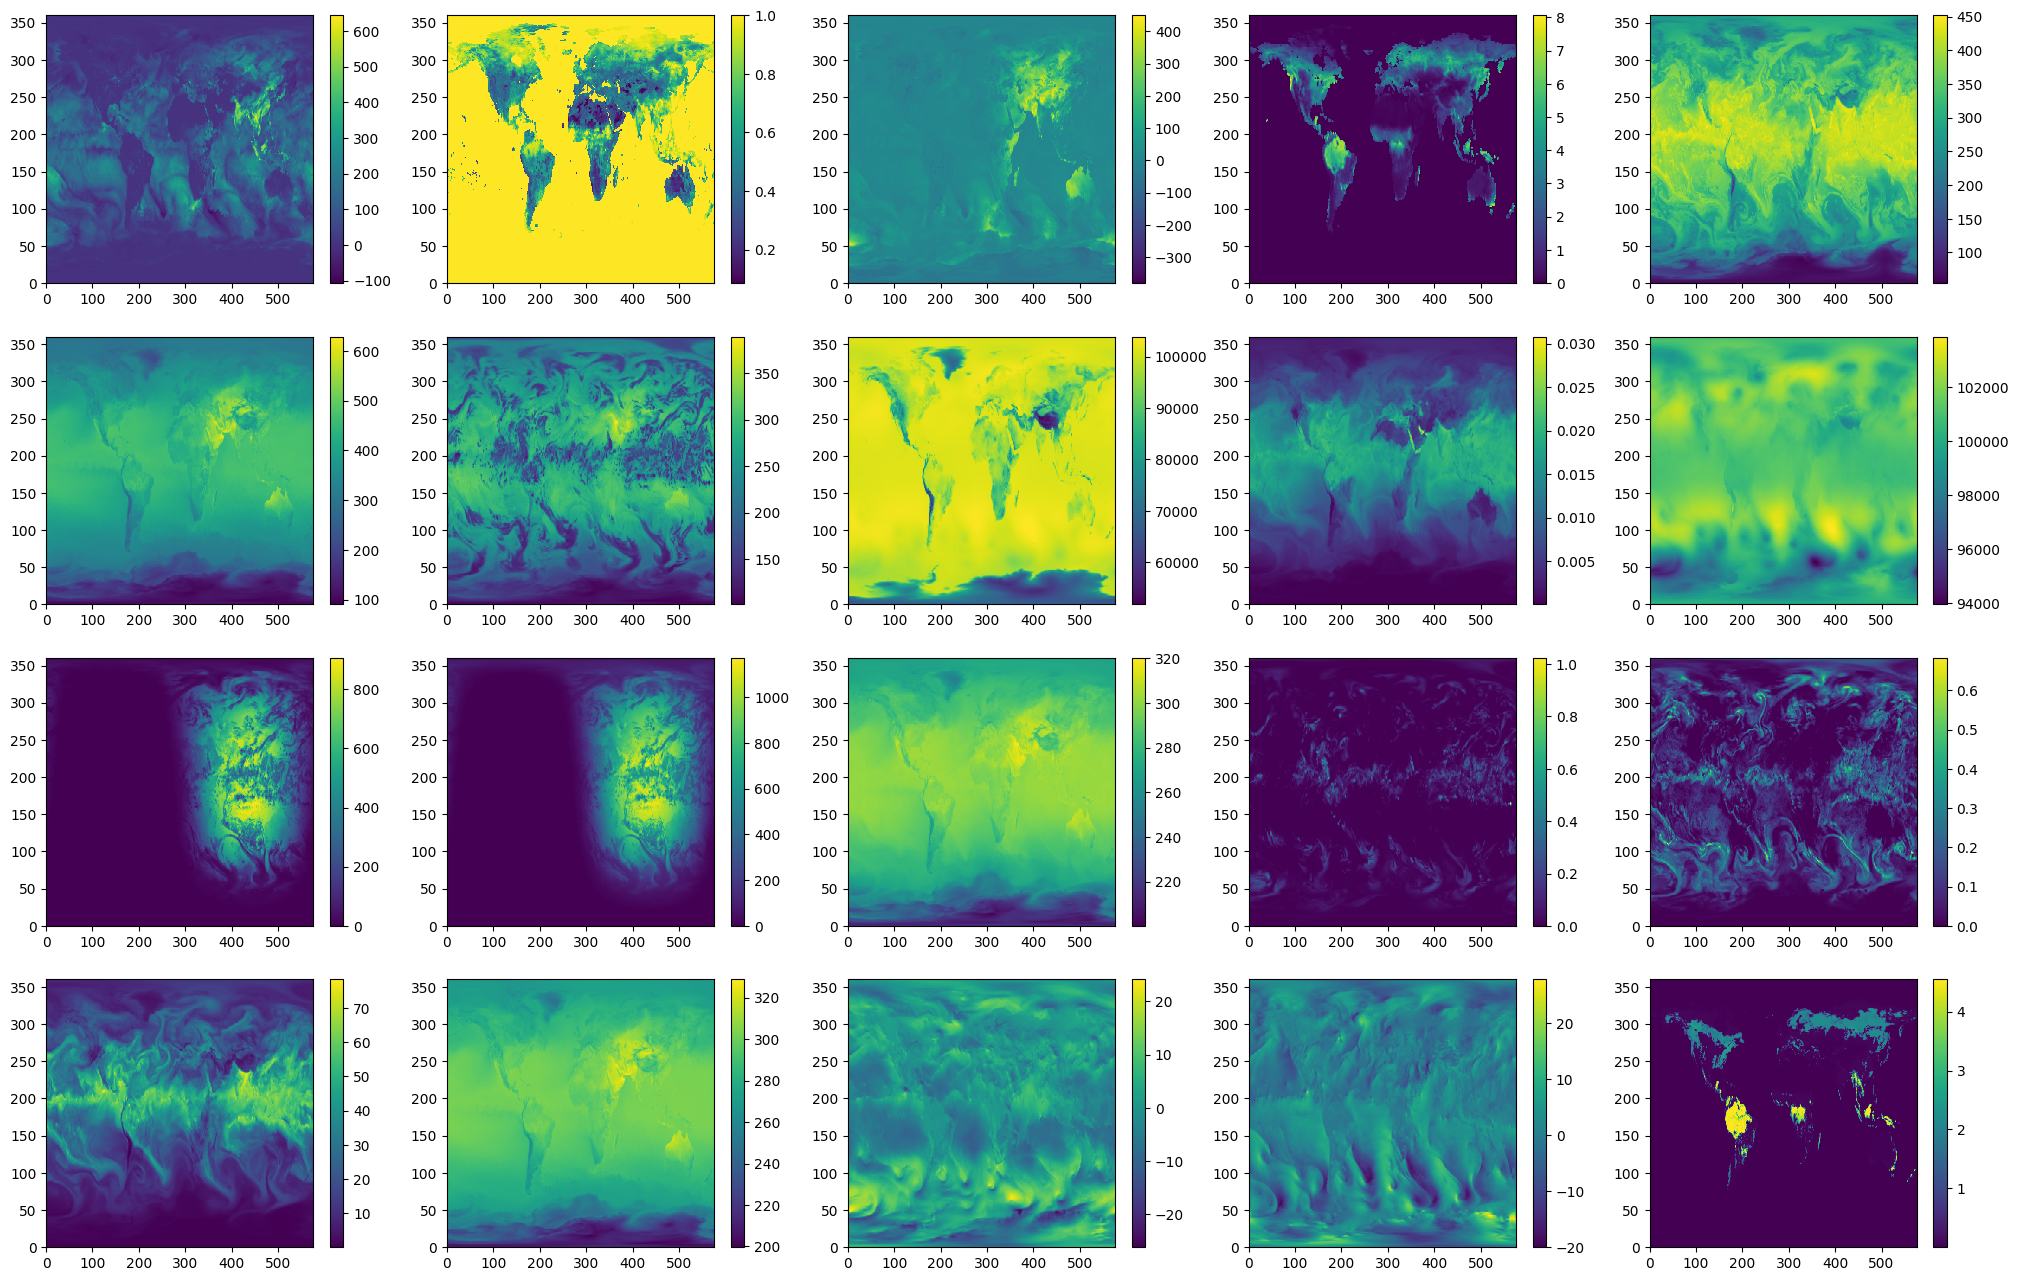

In [7]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(25, 16))
gs = GridSpec(4, 5)

lats = np.rad2deg(input_data["static"][0, 0])
lons = np.rad2deg(input_data["static"][0, 1])

for row_ind in range(4):
    for col_ind in range(5):
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        
        var_ind = row_ind * 5 + col_ind
        var = input_data["x"][0, -1, var_ind].numpy()

        m = ax.pcolormesh(var)
        plt.colorbar(m, ax=ax)
        
    

#### Vertically-resolved variables

The following table lists the vertically-resolved variables that occupy indices 20 - 159 in
the dynamic input.

| Input Index Range | Variable | Full Name                              | Units         |
|-------------------|----------|-----------------------------------------|---------------|
| 20-33             | CLOUD    | Cloud Fraction                          | unitless      |
| 34-47             | H        | Geopotential Height                     | m             |
| 48-61             | OMEGA    | Vertical Pressure Velocity              | Pa/s          |
| 62-75             | PL       | Pressure on Model Levels                | Pa            |
| 76-89             | QI       | Ice Water Mixing Ratio                  | kg/kg         |
| 90-103            | QL       | Liquid Water Mixing Ratio               | kg/kg         |
| 104-117           | QV       | Specific Humidity                       | kg/kg         |
| 118-131           | T        | Air Temperature                         | K             |
| 132-145           | U        | Eastward Wind                           | m/s           |
| 146-159           | V        | Northward Wind                          | m/s           |

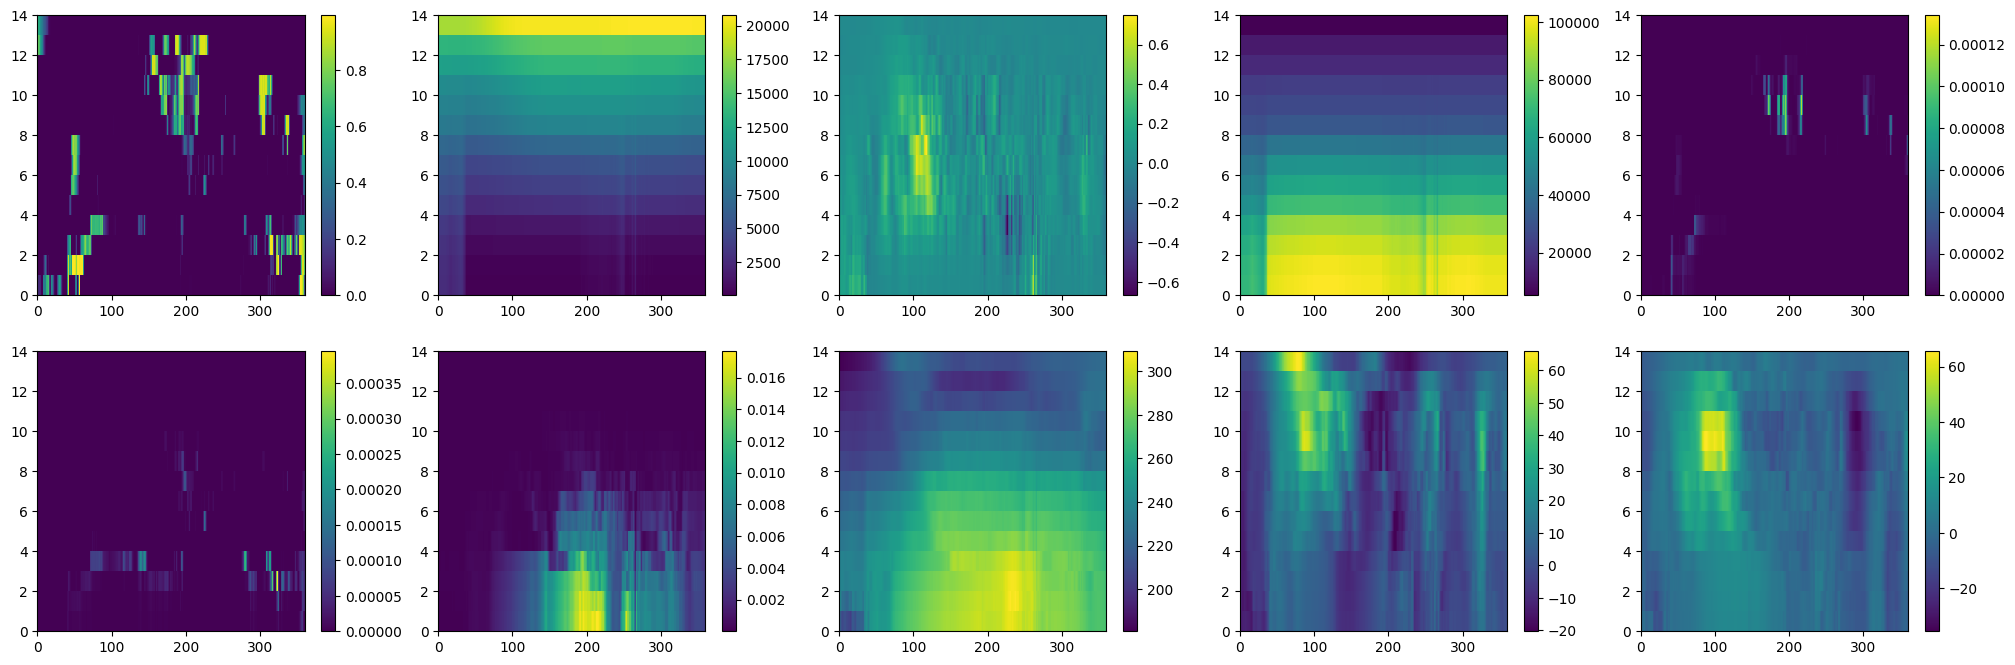

In [8]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(25, 8))
gs = GridSpec(2, 5)

lats = np.rad2deg(input_data["static"][0, 0])
lons = np.rad2deg(input_data["static"][0, 1])

for row_ind in range(2):
    for col_ind in range(5):
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        
        var_ind = 20 + (row_ind * 5 + col_ind) * 14
        var = input_data["x"][0, -1, var_ind: var_ind + 14, :, 576 // 2].numpy()

        m = ax.pcolormesh(np.flipud(var))
        plt.colorbar(m, ax=ax)

### Static input data

The static input data comprises the following variables:

| Input Index | Variable | Full Name                                   | Units                   |
|-------------|----------|---------------------------------------------|-------------------------|
| 0           |  LAT     | The latitude coordinate of each grid point  | **rad (!)**             |
| 1           |  LON     | The longitude coordinate of each grid point | **rad (!)**             |
| 2           |  DOY     | The sine of the day of the year             |  unitless               |
| 3           |  DOY     | The cosine of the day of the year           |  unitless               |
| 4           |  HOD     | The sine of the hour of the day             |  unitless               |
| 5           |  HOD     | The cosine of the hour of the day           |  unitless               |
| 6           | FRACI    | Sea Ice Fraction                            | unitless                |
| 7           | FRLAND   | Land Fraction                               | unitless                |
| 8           | FROCEAN  | Ocean Fraction                              | unitless                |
| 9           | PHIS     | Surface Geopotential Height                 | m²/s²                   |

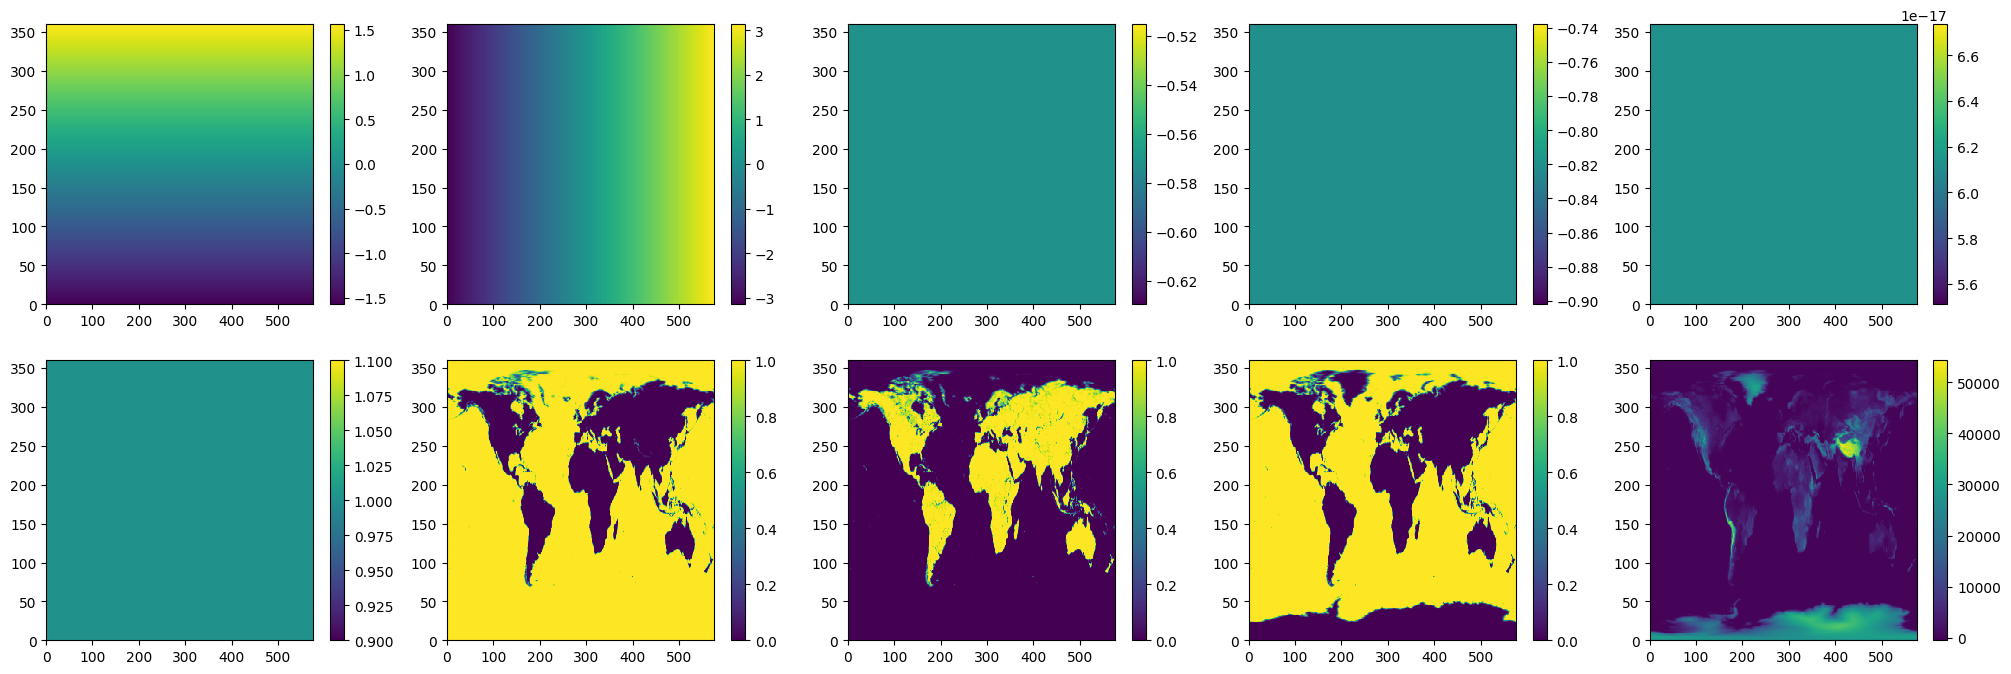

In [9]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(25, 8))
gs = GridSpec(2, 5)

lats = np.rad2deg(input_data["static"][0, 0])
lons = np.rad2deg(input_data["static"][0, 1])

for row_ind in range(2):
    for col_ind in range(5):
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        
        var_ind = row_ind * 5 + col_ind
        var = input_data["static"][0, var_ind].numpy()

        m = ax.pcolormesh(var)
        plt.colorbar(m, ax=ax)

## The model

In [10]:
scaling_factor_dir = Path("scaling_factors")

In [11]:
from fm4a.download import get_prithvi_wxc_scaling_factors
get_prithvi_wxc_scaling_factors(scaling_factor_dir)

/home/simon/miniforge3/envs/fm4a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
from fm4a.model import load_model
model = load_model(
    "small",
    scaling_factor_dir,
    weights="../data/weights/prithvi_wxc_small.pt"
)
model = model.eval().to(device="cuda:1")

In [13]:
batch = {name: tnsr.to(device="cuda:1") for name, tnsr in input_data.items()}

In [14]:
model.n_lats_px

360

In [15]:
batch["x"].shape

torch.Size([1, 2, 160, 360, 576])

In [16]:
576 // 32

18

In [38]:
import torch
global_mask = (np.random.rand(12, 18) > 0.25)
global_mask[7, :] = True

with torch.no_grad():
    pred = model.forward(batch, mask_global=torch.tensor(global_mask).to(device="cuda:1"))

tensor([[  7,  10,  16,  17,  20,  22,  23,  25,  26,  27,  28,  34,  35,  37,
          39,  43,  51,  60,  64,  65,  66,  70,  81,  84,  97, 100, 102, 103,
         110, 116, 118, 123, 146, 148, 158, 172, 176, 177, 183, 187, 189, 193,
         196, 201, 202, 207, 209, 212, 215]], device='cuda:1')


In [39]:
full_mask = np.repeat(np.repeat(global_mask, 30, -2), 32, -1)


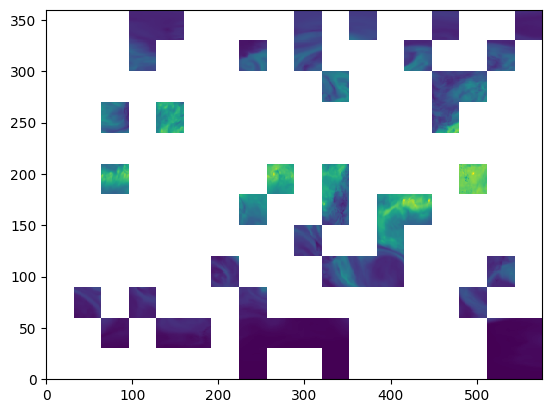

In [46]:
inpt = batch["x"][0, 1, 15].cpu().numpy().copy()
inpt[..., full_mask] = np.nan
plt.pcolormesh(inpt)
#plt.ylim(6 * 30, 9 * 30)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

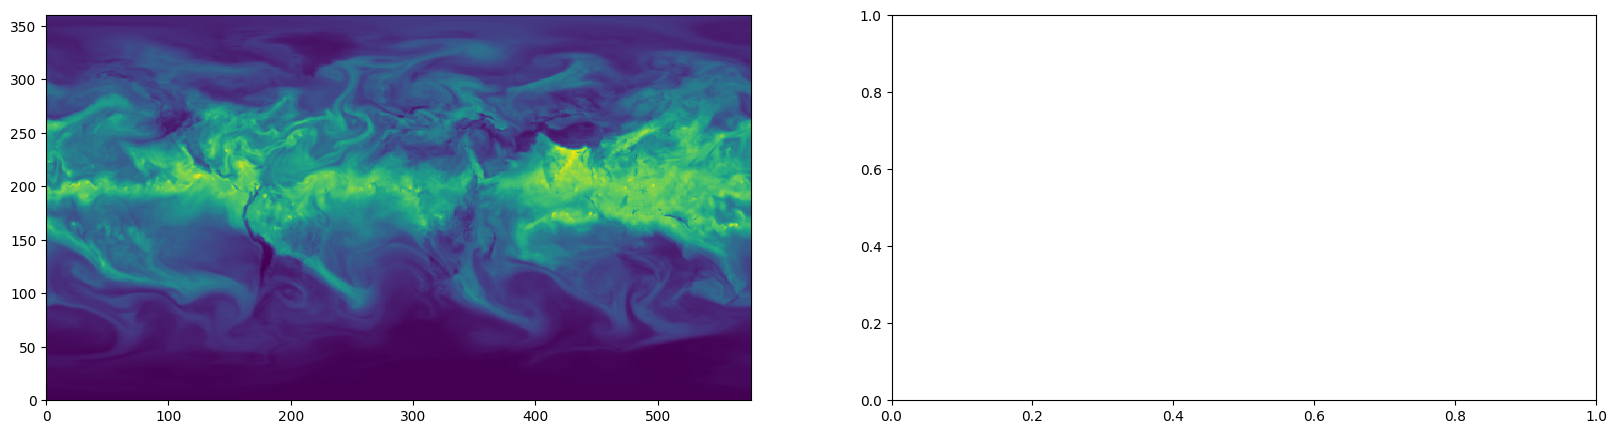

In [51]:
f, axs = plt.subplots(1, 2, figsize=(20, 5))
inpt = batch["x"][0, 1, 15].cpu().numpy().copy()

axs[0].pcolormesh(pred[0, 15].cpu().numpy())
axs[0].pcolormesh(inpt)

plt.colorbar()

In [18]:
model.encoder_shifter

SWINShiftNoBuffer()

In [78]:
from fm4a.definitions import SURFACE_VARS, STATIC_SURFACE_VARS, VERTICAL_VARS, LEVELS
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset

time_range = ("2020-01-01T00:00:00", "2020-01-01T23:59:59")

dataset = Merra2RolloutDataset(
    time_range=time_range,
    lead_time=lead_time,
    input_time=-input_time_step,
    data_path_surface="../data/merra-2/", #"input_data",
    data_path_vertical="../data/merra-2/", #"input_data",
    climatology_path_surface="input_data/climatology",
    climatology_path_vertical="input_data/climatology",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    levels=LEVELS,
    positional_encoding="fourier",
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

In [46]:
dataset = Merra2RolloutDataset(
    time_range=time_range,
    lead_time=lead_time,
    input_time=-input_time_step,
    data_path_surface="input_data",
    data_path_vertical="input_data",
    climatology_path_surface="input_data/climatology",
    climatology_path_vertical="input_data/climatology",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    levels=LEVELS,
    positional_encoding="fourier",
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

In [77]:
lead_time

12

In [10]:
data = xr.load_dataset("raw/constant/MERRA2_101.const_2d_asm_Nx.00000000.nc4")

In [82]:
import torch
from PrithviWxC.dataloaders.merra2_rollout import preproc
from PrithviWxC.rollout import rollout_iter

device = "cuda:0"
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}
data = next(iter(dataset))
batch = preproc([data], padding)


for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = rollout_iter(dataset.nsteps, model, batch)

TIMES ::  [datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 3, 0), datetime.datetime(2020, 1, 1, 6, 0), datetime.datetime(2020, 1, 1, 9, 0), datetime.datetime(2020, 1, 1, 12, 0), datetime.datetime(2020, 1, 1, 15, 0), datetime.datetime(2020, 1, 1, 18, 0), datetime.datetime(2020, 1, 1, 21, 0)]
TIMES ::  [datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 3, 0), datetime.datetime(2020, 1, 1, 6, 0), datetime.datetime(2020, 1, 1, 9, 0), datetime.datetime(2020, 1, 1, 12, 0), datetime.datetime(2020, 1, 1, 15, 0), datetime.datetime(2020, 1, 1, 18, 0), datetime.datetime(2020, 1, 1, 21, 0)]
TIMES ::  [datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 3, 0), datetime.datetime(2020, 1, 1, 6, 0), datetime.datetime(2020, 1, 1, 9, 0), datetime.datetime(2020, 1, 1, 12, 0), datetime.datetime(2020, 1, 1, 15, 0), datetime.datetime(2020, 1, 1, 18, 0), datetime.datetime(2020, 1, 1, 21, 0)]
TIMES ::  [datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2

In [80]:
torch.where((batch["x"] - batch_ref["x"]).abs() > 0.0)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [31]:
batch["x"].dtype

torch.float32

In [57]:
out.shape

torch.Size([1, 160, 360, 576])

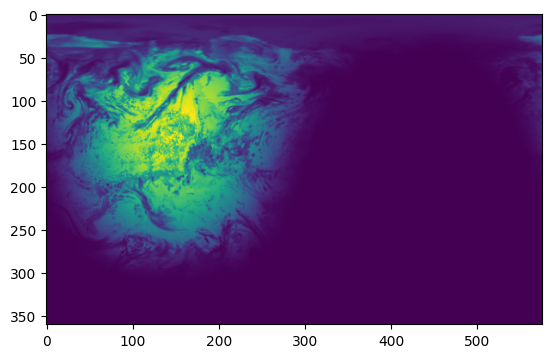

In [97]:
plt.imshow(batch["ys"][0, 1, 10].cpu())

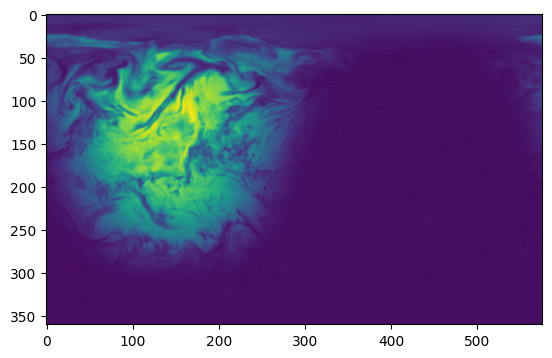

In [96]:
plt.imshow(out[0, 10].cpu())

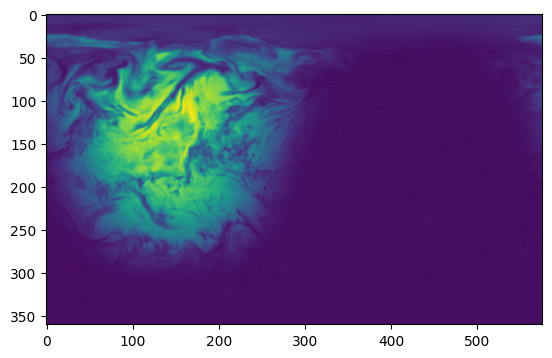

In [93]:
plt.imshow(batch["x"][0, 1, 10].cpu())

In [12]:
cd = xr.load_dataset("raw/constant/MERRA2_101.const_2d_ctm_Nx.00000000.nc4")

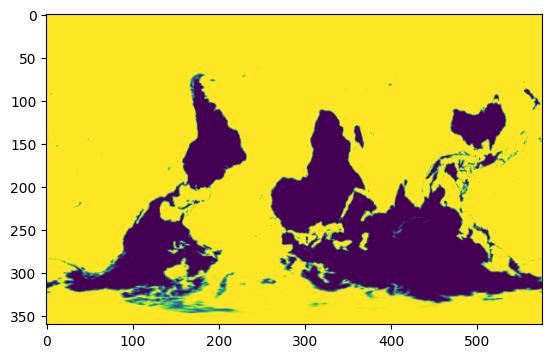

In [13]:
plt.imshow(batch["statics"][0, 0, 6].cpu())

In [14]:
torch.where(torch.isnan(batch["statics"]))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

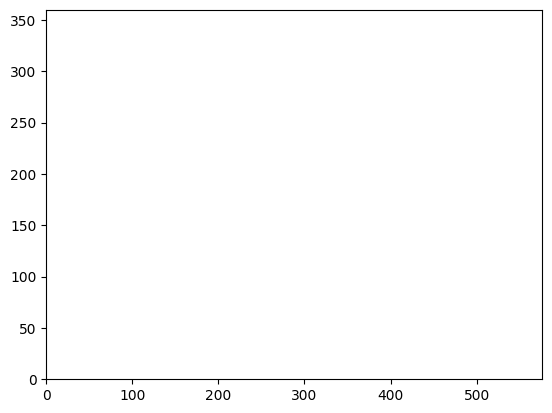

In [16]:
plt.pcolormesh(out[0, 0].cpu())

In [ ]:
from pathlib import Path
from fm4a.download import get_prithvi_wxc_input

download_dir = Path("raw")
input_data_dir = Path("input_data")

get_prithvi_wxc_input(
    np.datetime64("2020-01-01T06:00:00"),
    6,
    12,
    input_data_dir,
    download_dir,
)


In [ ]:
##

In [5]:
https://goldsmr5.gesdisc.eosdis.nasa.gov/data/MERRA2/M2I3NVASM.5.12.4/1970/01/MERRA2_400.inst3_3d_asm_Nv.19700101.nc4
xr.load_dataset("raw/constant/MERRA2_101.const_2d_asm_Nx.00000000.nc4")

<xarray.Dataset> Size: 5MB
Dimensions:    (lon: 576, lat: 361, time: 1)
Coordinates:
  * lon        (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * lat        (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time       (time) datetime64[ns] 8B 1992-01-02T03:00:00
Data variables:
    FRLAKE     (time, lat, lon) float32 832kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FRLAND     (time, lat, lon) float32 832kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FRLANDICE  (time, lat, lon) float32 832kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    FROCEAN    (time, lat, lon) float32 832kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    PHIS       (time, lat, lon) float32 832kB 2.758e+04 2.758e+04 ... 0.0 0.0
    SGH        (time, lat, lon) float32 832kB 11.49 11.49 11.49 ... 0.0 0.0 0.0
Attributes: (12/30)
    History:                           Updated file generated to remove AREA:...
    Comment:                           GMAO filename: d5124_m2_jan79.const_2d...
    Filename:                          MERRA2_101.const_2d_asm_Nx.00000000.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    LatitudeResolution:                0.5 
    LongitudeResolution:               0.625 
    DataResolution:                    0.5 x 0.625 
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/ME5QX6Q5IGGU
    Source:                            CVS tag: GEOSadas-5_12_4